## objective
1. predict the conversion rate
2. provide recommandation to increase conversion rate

In [1]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
%matplotlib inline

In [2]:
df = pd.read_csv('conversion_data.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [4]:
#check missing value
df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [5]:
# we need to first understand the current conversion rate
conversion_rate = df['converted'][df['converted'] == 1].count()/df['converted'].count()
print('the conversion rate is %.3f'%conversion_rate)

the conversion rate is 0.032


In [6]:
#check the unique value in counrty and source
df['country'].value_counts()

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

In [7]:
df['source'].value_counts()

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64

In [8]:
#check outlier for age
df[df['age']>100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [9]:
#remove outlier 
df = df[df['age']<100]

## exploratory analysis

### discrete variable

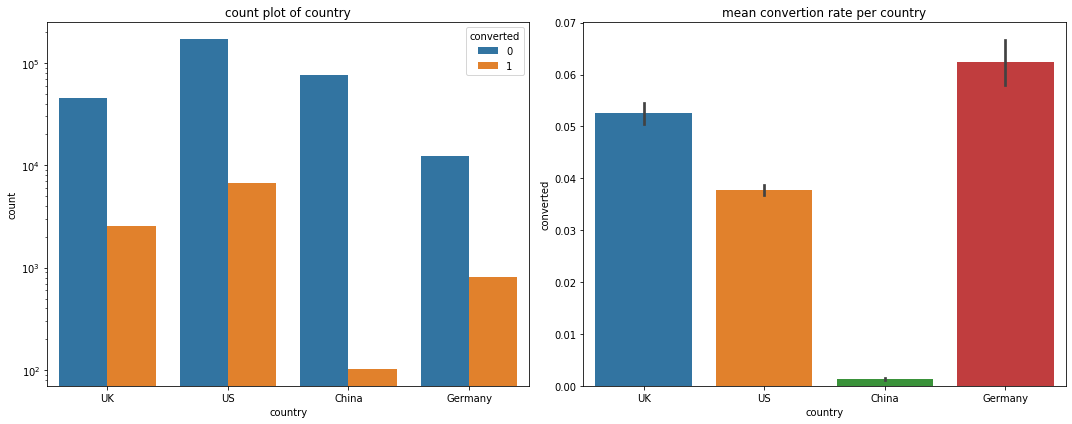

In [10]:
#visualization of different country vs convertion rate
group = df[['country','converted']].groupby('country').mean().reset_index()
fig, axes = plt.subplots(nrows=1,ncols=2,figsize = (15,6))
sns.countplot(x='country',hue='converted',data=df,ax=axes[0])
axes[0].set_title('count plot of country')
axes[0].set_yscale('log')
sns.barplot(x='country',y='converted',data=df,ax=axes[1])
axes[1].set_title('mean convertion rate per country')
plt.tight_layout()

Text(0.5, 1.0, 'mean convertion rate per user type')

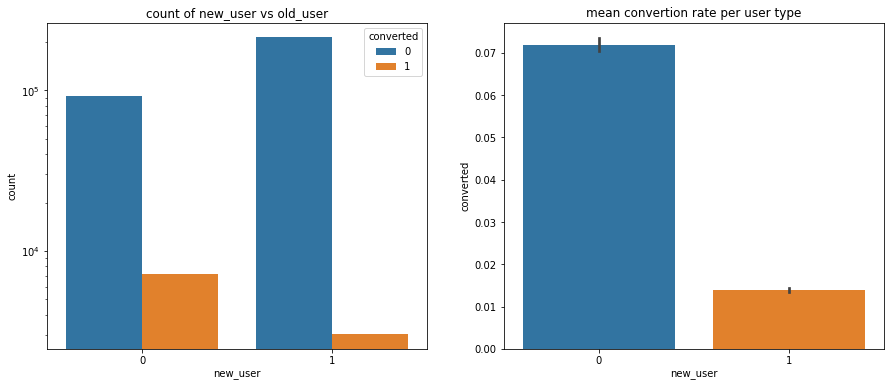

In [11]:
#visualization of different user 
group = df[['new_user','converted']].groupby('new_user').mean().reset_index()
group
fig, axes = plt.subplots(nrows = 1,ncols=2,figsize=(15,6))
sns.countplot(x='new_user',hue='converted',data=df,ax=axes[0])
axes[0].set_title('count of new_user vs old_user')
axes[0].set_yscale('log')
sns.barplot(x='new_user',y='converted',data=df,ax=axes[1])
axes[1].set_title('mean convertion rate per user type')

Text(0.5, 1.0, 'mean convertion rate per source type')

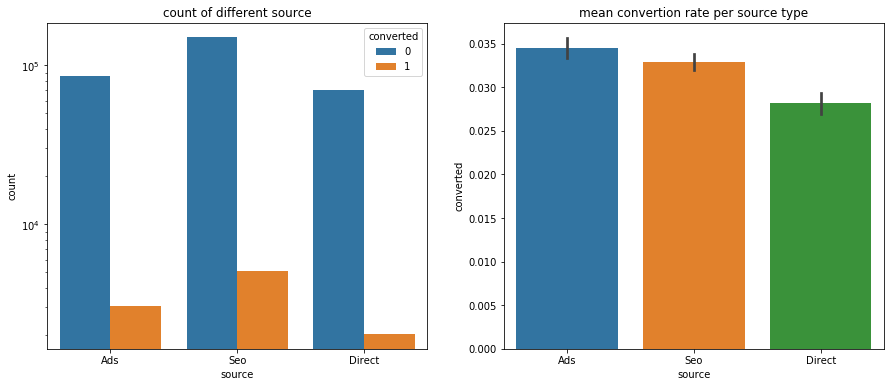

In [12]:
#visualization of different source
#visualization of different user 
group = df[['source','converted']].groupby('source').mean().reset_index()
group
fig, axes = plt.subplots(nrows = 1,ncols=2,figsize=(15,6))
sns.countplot(x='source',hue='converted',data=df,ax=axes[0])
axes[0].set_title('count of different source')
axes[0].set_yscale('log')
sns.barplot(x='source',y='converted',data=df,ax=axes[1])
axes[1].set_title('mean convertion rate per source type')

### continous variable

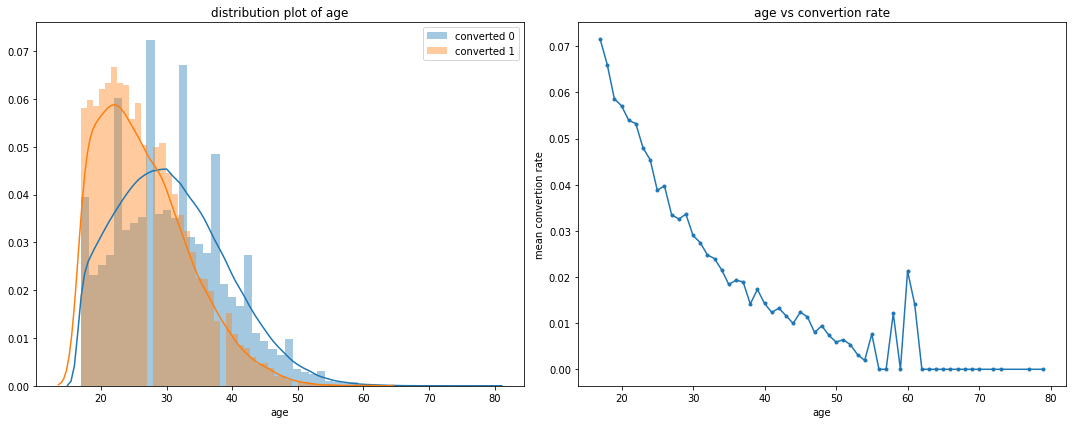

In [13]:
group = df[['age','converted']].groupby('age').mean().reset_index()
fig, axes = plt.subplots(nrows=1,ncols=2,figsize = (15,6))
sns.distplot(a=df[df['converted']==0]['age'],ax=axes[0],label='converted 0')
sns.distplot(a=df[df['converted']==1]['age'],ax=axes[0],label='converted 1')
axes[0].set_title('distribution plot of age')
axes[0].legend()

axes[1].plot(group['age'],group['converted'],'.-')
axes[1].set_xlabel('age')
axes[1].set_ylabel('mean convertion rate')
axes[1].set_title('age vs convertion rate')
plt.tight_layout()

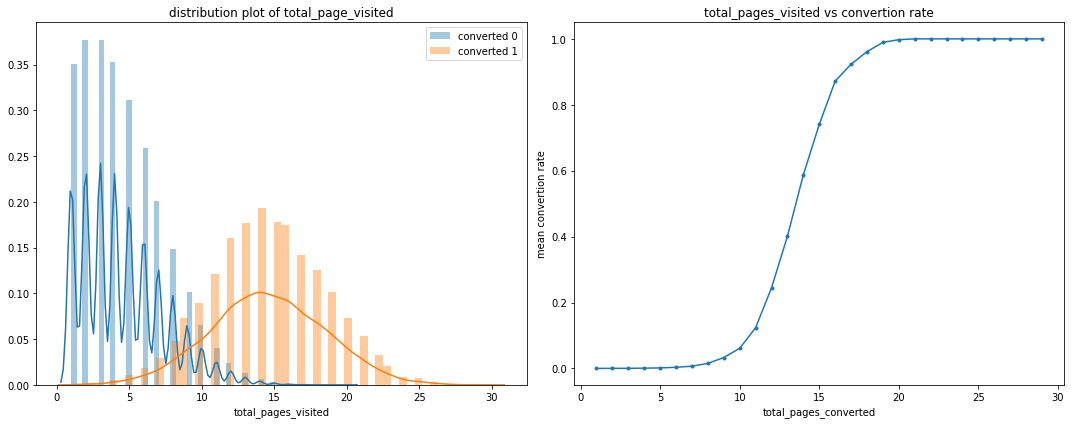

In [14]:
group = df[['total_pages_visited','converted']].groupby('total_pages_visited').mean().reset_index()

fig, axes = plt.subplots(nrows=1,ncols=2,figsize = (15,6))
sns.distplot(a=df[df['converted']==0]['total_pages_visited'],ax=axes[0],label='converted 0')
sns.distplot(a=df[df['converted']==1]['total_pages_visited'],ax=axes[0],label='converted 1')
axes[0].set_title('distribution plot of total_page_visited')
axes[0].legend()

axes[1].plot(group['total_pages_visited'],group['converted'],'.-')
axes[1].set_xlabel('total_pages_converted')
axes[1].set_ylabel('mean convertion rate')
axes[1].set_title('total_pages_visited vs convertion rate')
plt.tight_layout()

## machine learning

In [15]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_131"; Java(TM) SE Runtime Environment (build 1.8.0_131-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from /Users/jinq/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/yv/k3f6f5dd0rdg6hdcyqk24kch0000gn/T/tmp4f2q8jiz
  JVM stdout: /var/folders/yv/k3f6f5dd0rdg6hdcyqk24kch0000gn/T/tmp4f2q8jiz/h2o_jinq_started_from_python.out
  JVM stderr: /var/folders/yv/k3f6f5dd0rdg6hdcyqk24kch0000gn/T/tmp4f2q8jiz/h2o_jinq_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,4 months and 29 days !!!
H2O cluster name:,H2O_from_python_jinq_58ho28
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [16]:
# transform to H20 frame and make sure target variable is categorical
h2o_df = H2OFrame(df)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [17]:
# split into 70% training and 30% testing
strat_split = h2o_df['converted'].stratified_split(test_frac=0.3,seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

features = h2o_df.col_names[:-1]
target = 'converted'
print(train.shape,test.shape)

(221339, 6) (94859, 6)


In [18]:
#build random forest model
model = H2ORandomForestEstimator(balance_classes = True, ntrees = 50,max_depth = 20, score_each_iteration=True)
model.train(x=features, y=target,training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


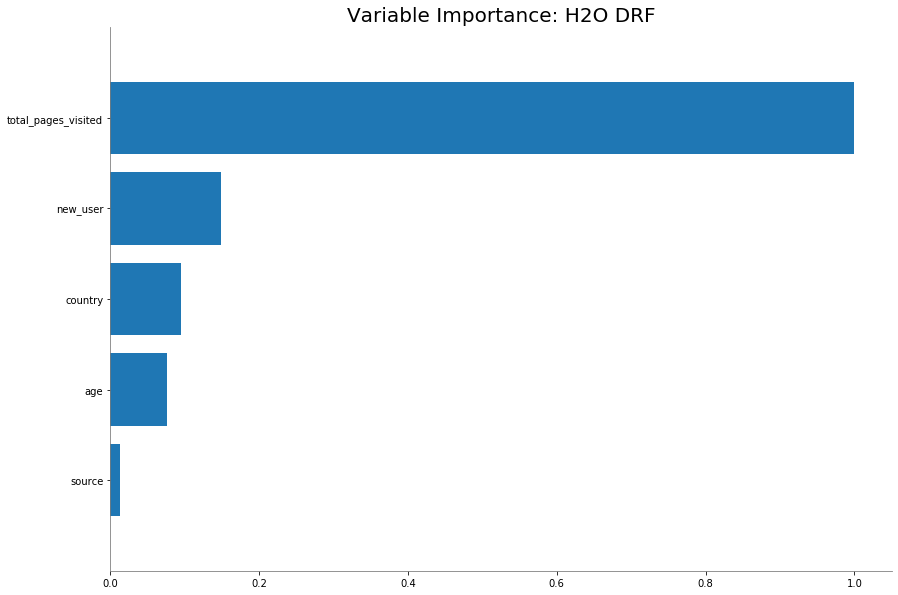

In [19]:
#variable importance
model.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


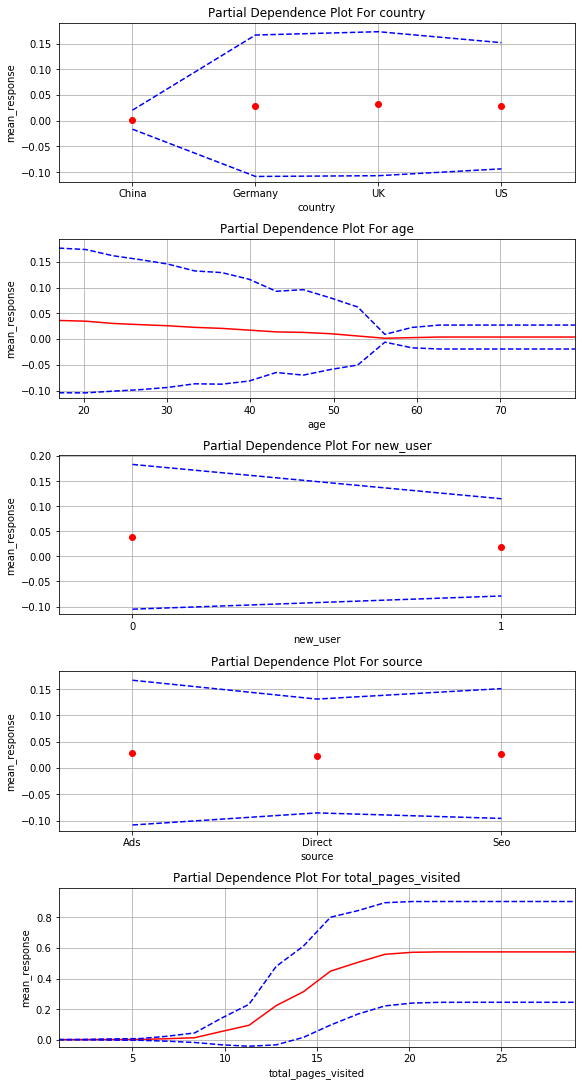

In [21]:
_ = model.partial_plot(train, cols=features, figsize=(8, 15))

### we only care about the trend not the y value
1. china is really bad and all other country are similar, UK being the best
2. the site works well for young people and it has no effect for people above 55. 
3. use an old account are much better than new user
4. source is irrelavant 

In [22]:
# make prediction
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

print(train_true.shape,train_pred.shape)

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr,train_tpr),3)
test_auc = np.round(auc(test_fpr, test_tpr),3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
(221339,) (221339,)


In [23]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91800
           1       0.85      0.62      0.72      3059

    accuracy                           0.98     94859
   macro avg       0.92      0.81      0.85     94859
weighted avg       0.98      0.98      0.98     94859



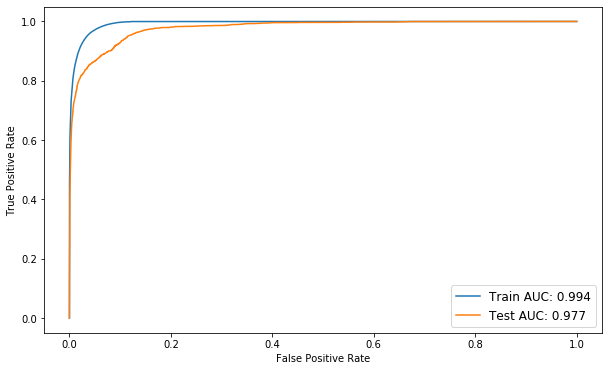

In [24]:
fig, ax = plt.subplots(figsize= (10,6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(fontsize=12)
plt.show()

In [25]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_bd00 closed.


### interpolation

1. we can see that total number of pages visited are proportionaly correlated to the conversion rate. >= 20 pages 
has a conversion rate of 1. we want to encourage the user to visit more pages
2. ads tend to have higher converison rate than SEO and direct marketing

### recommendation 
1. the site works well for young users and tell marketing to reach young people
2. user with old accounts do much better, target emails with offers to bring them back
3. chinese website performs poorly maybe its poorly translated need to fix the issue, priority
4. go through UI and figure out why it doesnt work for people over 55. 
5. if someone go thourgh a lot of page visits but doesnt convert, we can send them reminder

### conclusion always being about
1. terll marketing to get more of the good performing user segments
2. tell product to fix the bad performing ones. 